In [1]:
import numpy as np
import tensorflow as tf
from adult_modified import preprocess_adult_data
from sklearn import linear_model
import utils
import classifier as cl

In [2]:
seed = 1
dataset_orig_train, dataset_orig_test = preprocess_adult_data(seed = seed)

In [3]:
x_unprotected_train, x_protected_train = dataset_orig_train.features[:, :39], dataset_orig_train.features[:, 39:]
x_unprotected_test, x_protected_test = dataset_orig_test.features[:, :39], dataset_orig_test.features[:, 39:]
y_train, y_test = dataset_orig_train.labels.reshape((-1,)), dataset_orig_test.labels.reshape((-1,))
y_train, y_test = np.array(y_train, dtype= 'int32'), np.array(y_test, dtype='int32')

protected_regression = linear_model.LinearRegression(fit_intercept = False)
protected_regression.fit(x_unprotected_train, x_protected_train)
sensetive_directions = protected_regression.coef_

def projection_matrix(sensetive_directions):
    n, d = sensetive_directions.shape
    mx = np.identity(d)
    for vector in sensetive_directions:
        vector = vector/np.linalg.norm(vector, ord=2)
        vector = vector.reshape((-1,1))
        mx = mx - 0.99* vector @ vector.T
    return mx

unprotected_directions = projection_matrix(sensetive_directions)


In [4]:
x_unprotected_train, x_unprotected_test = tf.cast(x_unprotected_train, dtype = tf.float32), tf.cast(x_unprotected_test, dtype = tf.float32)
y_train, y_test = tf.one_hot(y_train, 2), tf.one_hot(y_test, 2)
unprotected_directions = tf.cast(unprotected_directions, dtype = tf.float32)


In [5]:
graph = utils.ClassifierGraph(50, 2)
graph = cl.Classifier(graph, x_unprotected_train, y_train, x_unprotected_test, y_test, num_steps=1000)

unprotected_directions = tf.cast(unprotected_directions, dtype = tf.float32)

Done step 200

Done step 400

Done step 600

Done step 800

Done step 1000



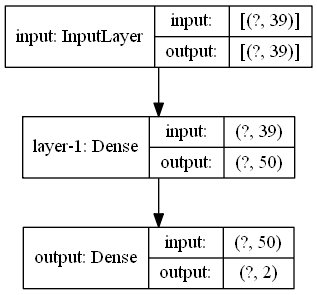

In [6]:
input = tf.keras.Input(shape=(39,), dtype='float32', name='input')
output = graph.call(input)
model = tf.keras.Model(inputs=input, outputs=output)
tf.keras.utils.plot_model(model, show_shapes=True)

In [7]:
pts = np.load('adversarial-points/perturbed_test_points1.npy')

In [8]:
def error(data):
    x, y = data
    x = tf.cast(x, dtype = tf.float32)
    return utils.EntropyLoss(y, graph(x))

purterbed_error = [error(data) for data in zip(pts, y_test)]

In [10]:
purterbed_error = [x.numpy() for x in purterbed_error]

In [14]:
import random
def purterb_mean(n = 9045):
    index = random.sample(range(n), 400)
    perturb_errors = [purterbed_error[i] for i in index]
    return np.mean(perturb_errors)

In [21]:
perturbed_means = [purterb_mean() for _ in range(10000)]

In [13]:
random.sample(range(100), 3)

[43, 13, 38]

In [1]:
import matplotlib.pyplot as plt
plt.hist(perturbed_means)
plt.show()
plt.savefig('perturbed-mean-entropy-hist.pdf')

NameError: name 'perturbed_means' is not defined

((array([-3.81060943, -3.58545756, -3.46184782, ...,  3.46184782,
          3.58545756,  3.81060943]),
  array([0.296645  , 0.30062485, 0.30078328, ..., 0.43991876, 0.44290802,
         0.4458866 ], dtype=float32)),
 (0.020130242168157352, 0.36663851141929626, 0.999485776847218))

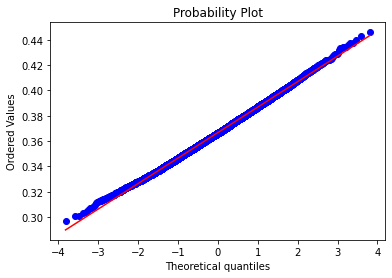

In [25]:
import scipy
scipy.stats.probplot(perturbed_means, plot=plt)


In [24]:
plt.show()